<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/variational_autoencoder/conv_vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available!


In [3]:
# set up the general configeration
def set_all_seeds(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load dataset from torchvision.datasets module
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

for inputs, _ in train_loader:
  print("Image batch dimension: ", inputs.shape)
  break

Number of training images:  60000
Number of test images:  10000
Image batch dimension:  torch.Size([128, 1, 28, 28])


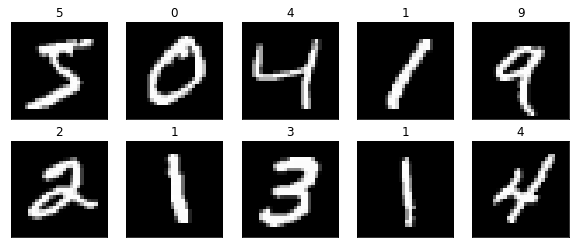

In [6]:
# visualize a batch of training data
def imshow(img):
  plt.imshow(np.squeeze(img), cmap="gray")

# obtain one batch of training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images
fig = plt.figure(figsize=(10,4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(inputs[idx])
  ax.set_title(str(targets[idx].item()))

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self, in_channels, latent_dim):
    super(VAE, self).__init__()

    # encoder
    self.enConv1 = nn.Conv2d(in_channels, 16, 5)
    self.enConv2 = nn.Conv2d(16, 32, 5)
    self.enFC1 = nn.Linear(20*20*32, latent_dim)
    self.enFC2 = nn.Linear(20*20*32, latent_dim)

    # decoder
    self.deFC1 = nn.Linear(latent_dim, 20*20*32)
    self.deConv1 = nn.ConvTranspose2d(32, 16, 5)
    self.deConv2 = nn.ConvTranspose2d(16, in_channels, 5)

  def encoder(self, x):
    x = F.relu(self.enConv1(x))
    x = F.relu(self.enConv2(x))
    x = x.view(-1, 20*20*32)
    mu = self.enFC1(x)
    log_var = self.enFC2(x)
    return mu, log_var

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + std * eps
    return sample

  def decoder(self, z):
    x = F.relu(self.deFC1(z))
    x = x.view(-1, 32, 20, 20)
    x = F.relu(self.deConv1(x))
    x = torch.sigmoid(self.deConv2(x))
    return x

  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.reparameterize(mu, log_var)
    recon_x = self.decoder(z)
    return recon_x, mu, log_var

in_channels = 1
latent_dim = 20

model = VAE(in_channels, latent_dim)
model.to(device)
print(model)

VAE(
  (enConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (enConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (enFC1): Linear(in_features=12800, out_features=20, bias=True)
  (enFC2): Linear(in_features=12800, out_features=20, bias=True)
  (deFC1): Linear(in_features=20, out_features=12800, bias=True)
  (deConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (deConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)


In [8]:
import torch.optim as optim

# define a loss function
def loss_function(recon_x, x, mu, logvar):
    recons_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recons_loss + kl_divergence

# specify optimizer
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)

In [9]:
# num of epochs to train the model
num_epochs = 20

# track training loss
train_losses = []

for epoch in range(num_epochs):
  # running train loss
  running_train_loss = 0.0
  for batch_idx, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, targets]
    inputs, _ = data
    # move tensor to the right device
    inputs = inputs.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    recon_inputs, mu, log_var = model(inputs)
    # calculate the batch loss
    loss = loss_function(recon_inputs, inputs, mu, log_var)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item()

  # calculate avg loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  train_losses.append(running_train_loss)

  print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, running_train_loss))

print("Finished training!")

Epoch: 1 	Training loss: 19109.451105
Epoch: 2 	Training loss: 14158.519379
Epoch: 3 	Training loss: 13707.746304
Epoch: 4 	Training loss: 13491.489245
Epoch: 5 	Training loss: 13341.150697
Epoch: 6 	Training loss: 13245.515075
Epoch: 7 	Training loss: 13158.190634
Epoch: 8 	Training loss: 13082.314730
Epoch: 9 	Training loss: 13022.024887
Epoch: 10 	Training loss: 12963.087716
Epoch: 11 	Training loss: 12922.124584
Epoch: 12 	Training loss: 12876.639857
Epoch: 13 	Training loss: 12845.440948
Epoch: 14 	Training loss: 12807.171750
Epoch: 15 	Training loss: 12781.612061
Epoch: 16 	Training loss: 12742.702344
Epoch: 17 	Training loss: 12714.175456
Epoch: 18 	Training loss: 12695.165689
Epoch: 19 	Training loss: 12668.899529
Epoch: 20 	Training loss: 12645.697087
Finished training!


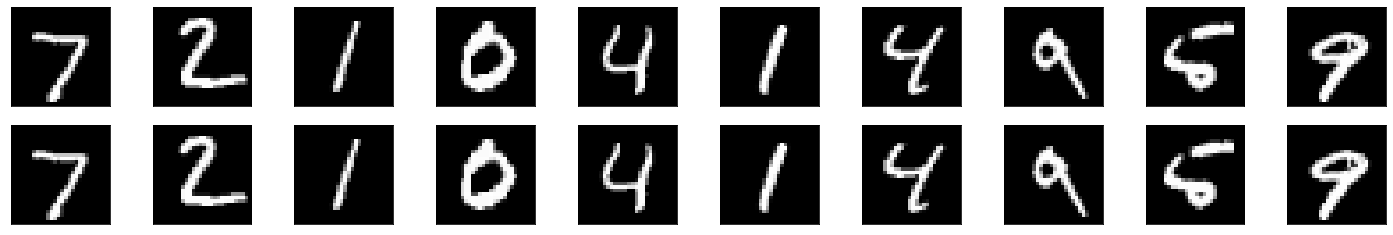

In [14]:
# visualize one batch of test images along with their reconstruction

# obtain one batch of test images
dataiter = iter(test_loader)
inputs, _ = dataiter.next()
inputs = inputs.to(device)

# get sample outputs
recon_inputs, _, _ = model(inputs)

## prepare images for display

inputs = inputs.numpy() if not train_on_gpu else inputs.cpu().numpy()
# resize outputs into a batch of images
recons_input = recon_inputs.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires grad
recon_inputs = recon_inputs.detach().numpy() if not train_on_gpu else recon_inputs.cpu().detach().numpy()

# display some inputs and their reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([inputs, recon_inputs], axes):
  for img, ax in zip(inputs, row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)